In [1]:
# import statements
import torch.nn as nn
import torch
from pycocotools.coco import COCO
import numpy as np
import random
import os
import torch
from PIL import Image
import torchvision.transforms as tvt
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import copy
import cv2

# setting seeds for consistency (reference: Lecture 2 and HW 2)
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False
os.environ["PYTHONHASHSEED"] = str(seed)

# global constants
dataDir = "./train2017"
annFileTraining = "./annotations/instances_train2017.json"
annFileValidation = "./annotations/instances_val2017.json"
classList = ["cake", "dog", "motorcycle"]

# initializing COCO for training data
coco_train = COCO(annFileTraining)
catIds_train = coco_train.getCatIds(catNms=["cake", "dog", "motorcycle"])
cats_train = coco_train.loadCats(catIds_train)
catNms_train = {cats_train.index(cat): cat["name"] for cat in cats_train}

# intializing COCO for validation data
coco_val = COCO(annFileValidation)
catIds_val = coco_val.getCatIds(catNms=["cake", "dog", "motorcycle"])
cats_val = coco_val.loadCats(catIds_val)
catNms_val = {cats_train.index(cat): cat["name"] for cat in cats_val}

loading annotations into memory...
Done (t=12.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [2]:
# function to retrieve data from COCO dataset and arrange them in training and
# validation dictionaries
def getData():
    trainingData = {cat: [] for cat in catNms_train.values()}
    validationData = {cat: [] for cat in catNms_val.values()}

    for cat, catNm in zip(catIds_train, catNms_train.keys()):
        imagesId_train = np.random.choice(
            coco_train.getImgIds(catIds=cat), size=2925, replace=False
        )
        print("Creating Training Data for", catNms_val[catNm], "category")
        for index in imagesId_train:
            annIds = coco_train.getAnnIds(
                imgIds=coco_train.loadImgs(int(index))[0]["id"],
                catIds=catIds_train,
                iscrowd=False,
            )
            if len(annIds) == 1:
                anns = coco_train.loadAnns(annIds)
                if anns[0]["area"] >= 200 * 200:
                    name = coco_train.loadImgs(int(index))[0]["file_name"]
                    image = Image.open("./train2017/" + name).convert("RGB")
                    rw, rh = image.size
                    mask_array = np.zeros((rh, rw))
                    mask_array = np.maximum(coco_train.annToMask(anns[0]), mask_array)
                    mask_array = cv2.resize(
                        mask_array, (256, 256), interpolation=cv2.INTER_NEAREST
                    )
                    image = image.resize((256, 256))
                    trainingData[catNms_train[catNm]].append((image, mask_array))

    for cat, catNm in zip(catIds_val, catNms_val.keys()):
        imagesId_val = np.random.choice(
            coco_val.getImgIds(catIds=cat), size=100, replace=False
        )
        print("Creating Validation Data for", catNms_val[catNm], "category")
        for index in imagesId_val:
            annIds = coco_val.getAnnIds(
                imgIds=coco_val.loadImgs(int(index))[0]["id"],
                catIds=catIds_val,
                iscrowd=False,
            )
            if len(annIds) == 1:
                anns = coco_val.loadAnns(annIds)
                if anns[0]["area"] >= 200 * 200:
                    name = coco_val.loadImgs(int(index))[0]["file_name"]
                    image = Image.open("./val2017/" + name).convert("RGB")
                    rw, rh = image.size
                    mask_array = np.zeros((rh, rw))
                    mask_array = np.maximum(coco_val.annToMask(anns[0]), mask_array)
                    mask_array = cv2.resize(
                        mask_array, (256, 256), interpolation=cv2.INTER_NEAREST
                    )
                    image = image.resize((256, 256))
                    validationData[catNms_val[catNm]].append((image, mask_array))
    print("Training Data and Validation Data Created")
    return trainingData, validationData

In [3]:
def plot_images(trainingData):
    fig, axes = plt.subplots(9, 2, figsize=(10, 10))
    plt.tight_layout()
    for i, cat in enumerate(catNms_train.values()):
        for j in range(3):
            image = np.array(trainingData[cat][j][0])
            mask = np.array(trainingData[cat][j][1])
            axes[3 * i + j, 0].imshow(image)
            axes[3 * i + j, 1].imshow(mask)
            axes[3 * i + j, 0].axis("off")
            axes[3 * i + j, 1].axis("off")
            axes[3 * i + j, 0].set_title(f"Image: {cat} {j + 1}")
            axes[3 * i + j, 1].set_title(f"Mask: {cat} {j + 1}")
    plt.show()

In [4]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, type, trainingData, validationData):
        super()
        if type == "train":
            self.data = list(trainingData.values())
        elif type == "validation":
            self.data = list(validationData.values())
        else:
            return ValueError(
                "Type is incorrect. Should be either 'train' or 'validation'"
            )

        image_mean = torch.zeros(3)
        image_std = torch.zeros(3)
        mask_mean = torch.zeros(1)
        mask_std = torch.zeros(1)

        self.imgs = []
        self.masks = []

        for cat in self.data:
            for img in cat:
                self.imgs.append(img[0])
                self.masks.append(img[1])

        for img in self.imgs:
            image_mean += torch.mean(tvt.ToTensor()(img), dim=(1, 2))
            image_std += torch.std(tvt.ToTensor()(img), dim=(1, 2))
        image_mean /= len(self.imgs)
        image_std /= len(self.imgs)

        for img in self.imgs:
            mask_mean += torch.mean(tvt.ToTensor()(img))
            mask_std += torch.std(tvt.ToTensor()(img))
        mask_mean /= len(self.masks)
        mask_std /= len(self.masks)

        self.img_transform = tvt.Compose(
            [tvt.ToTensor(), tvt.Normalize(image_mean, image_std)]
        )

        self.mask_transform = tvt.Compose(
            [tvt.ToTensor(), tvt.Normalize(mask_mean, mask_std)]
        )

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        image = self.img_transform(self.imgs[index])
        mask = self.mask_transform(self.masks[index])
        return image, mask

In [5]:
class SkipBlockDN(nn.Module):
    """
    This class for the skip connections in the downward leg of the "U"

    Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockDN
    """

    def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
        super(SkipBlockDN, self).__init__()
        self.downsample = downsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        if downsample:
            self.downsampler = nn.Conv2d(in_ch, out_ch, 1, stride=2)

    def forward(self, x):
        identity = x
        out = self.convo1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        if self.in_ch == self.out_ch:
            out = self.convo2(out)
            out = self.bn2(out)
            out = nn.functional.relu(out)
        if self.downsample:
            out = self.downsampler(out)
            identity = self.downsampler(identity)
        if self.skip_connections:
            if self.in_ch == self.out_ch:
                out = out + identity
            else:
                out = out + torch.cat((identity, identity), dim=1)
        return out


class SkipBlockUP(nn.Module):
    """
    This class is for the skip connections in the upward leg of the "U"

    Class Path:   DLStudio  ->  SemanticSegmentation  ->  SkipBlockUP
    """

    def __init__(self, in_ch, out_ch, upsample=False, skip_connections=True):
        super(SkipBlockUP, self).__init__()
        self.upsample = upsample
        self.skip_connections = skip_connections
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.convoT1 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
        self.convoT2 = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        if upsample:
            self.upsampler = nn.ConvTranspose2d(
                in_ch, out_ch, 1, stride=2, dilation=2, output_padding=1, padding=0
            )

    def forward(self, x):
        identity = x
        out = self.convoT1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        out = nn.ReLU(inplace=False)(out)
        if self.in_ch == self.out_ch:
            out = self.convoT2(out)
            out = self.bn2(out)
            out = nn.functional.relu(out)
        if self.upsample:
            out = self.upsampler(out)
            identity = self.upsampler(identity)
        if self.skip_connections:
            if self.in_ch == self.out_ch:
                out = out + identity
            else:
                out = out + identity[:, self.out_ch :, :, :]
        return out


class mUnet(nn.Module):
    """
    This network is called mUnet because it is intended for segmenting
    out multiple objects simultaneously form an image. [A weaker reason for
    "Multi" in the name of the class is that it uses skip connections not
    only across the two arms of the "U", but also also along the arms.]  The
    classic UNET was first proposed by Ronneberger, Fischer and Brox in the
    paper "U-Net: Convolutional Networks for Biomedical Image Segmentation".
    Their UNET extracts binary masks for the cell pixel blobs of interest
    in biomedical images.  The output of their UNET therefore can therefore
    be treated as a pixel-wise binary classifier at each pixel position.

    The mUnet presented here, on the other hand, is meant specifically
    for simultaneously identifying and localizing multiple objects in a
    given image.  Each object type is assigned a separate channel in the
    output of the network.

    I have created a dataset, PurdueShapes5MultiObject, for experimenting
    with mUnet.  Each image in this dataset contains a random number of
    selections from five different shapes, with the shapes being randomly
    scaled, oriented, and located in each image.  The five different shapes
    are: rectangle, triangle, disk, oval, and star.

    Class Path:   DLStudio  ->  SemanticSegmentation  ->  mUnet
    """

    def __init__(self, skip_connections=True, depth=16):
        super(mUnet, self).__init__()
        self.depth = depth // 2
        self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
        ##  For the DN arm of the U:
        self.bn1DN = nn.BatchNorm2d(64)
        self.bn2DN = nn.BatchNorm2d(128)
        self.skip64DN_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64DN_arr.append(
                SkipBlockDN(64, 64, skip_connections=skip_connections)
            )
        self.skip64dsDN = SkipBlockDN(
            64, 64, downsample=True, skip_connections=skip_connections
        )
        self.skip64to128DN = SkipBlockDN(64, 128, skip_connections=skip_connections)
        self.skip128DN_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128DN_arr.append(
                SkipBlockDN(128, 128, skip_connections=skip_connections)
            )
        self.skip128dsDN = SkipBlockDN(
            128, 128, downsample=True, skip_connections=skip_connections
        )
        ##  For the UP arm of the U:
        self.bn1UP = nn.BatchNorm2d(128)
        self.bn2UP = nn.BatchNorm2d(64)
        self.skip64UP_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64UP_arr.append(
                SkipBlockUP(64, 64, skip_connections=skip_connections)
            )
        self.skip64usUP = SkipBlockUP(
            64, 64, upsample=True, skip_connections=skip_connections
        )
        self.skip128to64UP = SkipBlockUP(128, 64, skip_connections=skip_connections)
        self.skip128UP_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128UP_arr.append(
                SkipBlockUP(128, 128, skip_connections=skip_connections)
            )
        self.skip128usUP = SkipBlockUP(
            128, 128, upsample=True, skip_connections=skip_connections
        )
        self.conv_out = nn.ConvTranspose2d(
            64, 1, 3, stride=2, dilation=2, output_padding=1, padding=2
        )

    def forward(self, x):
        ##  Going down to the bottom of the U:
        x = nn.MaxPool2d(2, 2)(nn.functional.relu(self.conv_in(x)))
        for i, skip64 in enumerate(self.skip64DN_arr[: self.depth // 4]):
            x = skip64(x)

        num_channels_to_save1 = x.shape[1] // 2
        save_for_upside_1 = x[:, :num_channels_to_save1, :, :].clone()
        x = self.skip64dsDN(x)
        for i, skip64 in enumerate(self.skip64DN_arr[self.depth // 4 :]):
            x = skip64(x)
        x = self.bn1DN(x)
        num_channels_to_save2 = x.shape[1] // 2
        save_for_upside_2 = x[:, :num_channels_to_save2, :, :].clone()
        x = self.skip64to128DN(x)
        for i, skip128 in enumerate(self.skip128DN_arr[: self.depth // 4]):
            x = skip128(x)

        x = self.bn2DN(x)
        num_channels_to_save3 = x.shape[1] // 2
        save_for_upside_3 = x[:, :num_channels_to_save3, :, :].clone()
        for i, skip128 in enumerate(self.skip128DN_arr[self.depth // 4 :]):
            x = skip128(x)
        x = self.skip128dsDN(x)
        ## Coming up from the bottom of U on the other side:
        x = self.skip128usUP(x)
        for i, skip128 in enumerate(self.skip128UP_arr[: self.depth // 4]):
            x = skip128(x)
        x[:, :num_channels_to_save3, :, :] = save_for_upside_3
        x = self.bn1UP(x)
        for i, skip128 in enumerate(self.skip128UP_arr[: self.depth // 4]):
            x = skip128(x)
        x = self.skip128to64UP(x)
        for i, skip64 in enumerate(self.skip64UP_arr[self.depth // 4 :]):
            x = skip64(x)
        x[:, :num_channels_to_save2, :, :] = save_for_upside_2
        x = self.bn2UP(x)
        x = self.skip64usUP(x)
        for i, skip64 in enumerate(self.skip64UP_arr[: self.depth // 4]):
            x = skip64(x)
        x[:, :num_channels_to_save1, :, :] = save_for_upside_1
        x = self.conv_out(x)
        return x

In [6]:
def dice_loss(preds: torch.Tensor, ground_truth: torch.Tensor, epsilon=1e-6):
    preds = torch.flatten(preds)
    ground_truth = torch.flatten(ground_truth)
    numerator = torch.sum(torch.dot(preds, ground_truth))
    denominator = torch.dot(preds, preds) + torch.dot(ground_truth, ground_truth)
    dice_coeffecient = (2 * numerator + epsilon) / (denominator + epsilon)
    return 1 - dice_coeffecient

In [7]:
def training(net, training_dataLoader, net_path):
    device = torch.device("cuda:0")
    model = copy.deepcopy(net)
    model = net.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
    loss = []
    for epoch in range(8):
        running_loss = 0.0
        for i, data in enumerate(training_dataLoader):
            img_tensor, mask_tensor = data
            img_tensor = img_tensor.to(device)
            mask_tensor = mask_tensor.type(torch.FloatTensor)
            mask_tensor = mask_tensor.to(device)
            optimizer.zero_grad()
            output = model(img_tensor)
            seg_loss = (dice_loss(output, mask_tensor) * 20) + criterion(
                output, mask_tensor
            )
            seg_loss.backward()
            optimizer.step()
            running_loss += seg_loss.item()

            if i % 20 == 19:
                avg_loss = running_loss / float(20)
                loss.append(avg_loss)
                print(
                    "Epoch:",
                    epoch + 1,
                    "Batch:",
                    i + 1,
                    "=> ",
                    "Loss:",
                    round(avg_loss, 6),
                )
                running_loss = 0.0

    torch.save(model.state_dict(), net_path)
    print("\nFinished Training\n")
    plt.plot(loss)
    plt.title("Training Loss with MSE+DICE")
    plt.ylabel("Segmentation Loss")
    plt.xlabel("Iterations")
    plt.savefig("training_loss_mse_dice.png")
    plt.show()

In [8]:
def validation(net, valDataset, netpath):
    device = (
        torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    )
    net.load_state_dict(torch.load(netpath, map_location=device))
    net.eval()
    net = net.to(device)
    motorcycle_idx = random.sample(range(0, 18), 5)
    dog_idx = random.sample(range(18, 50), 5)
    cake_idx = random.sample(range(50, 74), 5)
    idxs = [motorcycle_idx, dog_idx, cake_idx]
    for cat in idxs:
        fig, axes = plt.subplot(5, 3)
        for idx in range(len(cat)):
            img = valDataset[idx][0]
            mask = valDataset[idx][1]
            pred = net(img)
            axes[idx, 0].imshow(img)
            axes[idx, 1].imshow(mask)
            axes[idx, 2].imshow(pred)
            axes[idx, 0].axis("off")
            axes[idx, 1].axis("off")
            axes[idx, 2].axis("off")
            axes[idx, 0].set_title("Image")
            axes[idx, 1].set_title("Target")
            axes[idx, 2].set_title("Predicted")
        plt.show()

In [9]:
trainingData, validationData = getData()
print("Stats about Training Data and Validation Data")
print("Training Data Information:")
print("\t Number of Cake Images:", len(trainingData["cake"]))
print("\t Number of Dog Images:", len(trainingData["dog"]))
print("\t Number of Motorcycle Images:", len(trainingData["motorcycle"]))
print(
    "\t Total Number of Training Images:",
    len(trainingData["cake"])
    + len(trainingData["dog"])
    + len(trainingData["motorcycle"]),
)
print("Validation Data Information:")
print("\t Number of Cake Images:", len(validationData["cake"]))
print("\t Number of Dog Images:", len(validationData["dog"]))
print("\t Number of Motorcycle Images:", len(validationData["motorcycle"]))
print(
    "\t Total Number of Validation Images:",
    len(validationData["cake"])
    + len(validationData["dog"])
    + len(validationData["motorcycle"]),
)

Creating Training Data for motorcycle category
Creating Training Data for dog category
Creating Training Data for cake category
Creating Validation Data for motorcycle category
Creating Validation Data for dog category
Creating Validation Data for cake category
Training Data and Validation Data Created
Stats about Training Data and Validation Data
Training Data Information:
	 Number of Cake Images: 749
	 Number of Dog Images: 723
	 Number of Motorcycle Images: 657
	 Total Number of Training Images: 2129
Validation Data Information:
	 Number of Cake Images: 21
	 Number of Dog Images: 28
	 Number of Motorcycle Images: 17
	 Total Number of Validation Images: 66


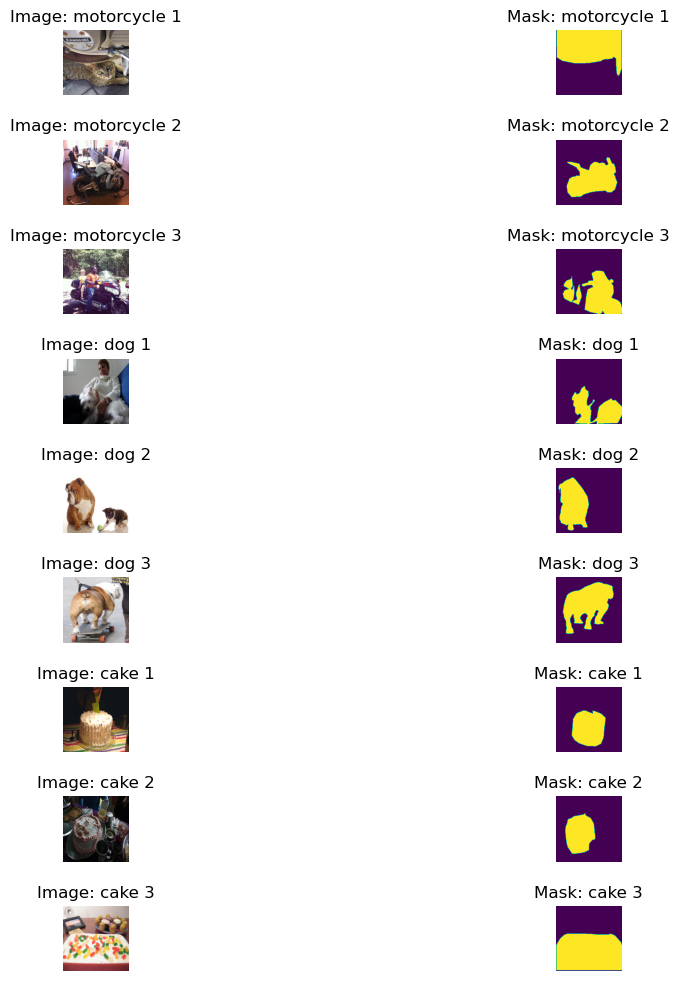

In [10]:
plot_images(trainingData)

In [11]:
trainDataset = ImageDataset(
    trainingData=trainingData, validationData=validationData, type="train"
)
valDataset = ImageDataset(
    validationData=validationData, trainingData=trainingData, type="validation"
)
trainDL = DataLoader(dataset=trainDataset, batch_size=25, shuffle=True)
valDL = DataLoader(dataset=valDataset, batch_size=25, shuffle=True)
net = mUnet()
num_layers = len(list(net.parameters()))
total_params = sum(param.numel() for param in net.parameters())
print("Number of Layers:", num_layers)
print("Number of Parameters:", total_params)

Number of Layers: 324
Number of Parameters: 6996801


In [12]:
training(net, trainDL, "./net.pth")

KeyboardInterrupt: 

In [ ]:
validation(net, valDataset, "./net.pth")